Tipo de problema:
- Clasificación supervisada

Objetivos:

- Desarrollar un sistema que le permita al usuario saber el nivel de fitness en base a la informacion ingresada.

- Clasificar el nivel de fitness del usuario en base a las variables fisiologicas y de entrenamiento que describen la aptitud fisica

- Input (X):
  - Variables fisiologicas y de entrenamiento que describen la aptitud fisica (el fitness)

- Target (y): `Experience_Level`
  1 → Beginner
  2 → Intermediate
  3 → Advanced

- La UI la voy a desarrollar con Nuxt (no veremos temas del codigo de la UI en este apartado), este sera el flujo a grandes rasgos:
  - Es un modulo en donde el usuario pueda ingresar sus datos
  - Desde la UI se mandara a llamar un endpoint (que se desarrollara con FastAPI y Python)
  - El endpoint mandara a llamar un metodo que contendra un pipeline de lcasificacion en base a los datos enviados por el usuario y el analisis de obtenido de nuestro proceso de machine learning

In [1]:
# pip install pandas numpy matplotlib seaborn joblib scikit-learn
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import joblib

In [2]:
sns.set(style="whitegrid")

In [3]:
df = pd.read_csv("../datasets/2-fitness-tracker-dataset-cleaned.csv")

2. Exploratory Data Analysis (EDA) especifico para la clasificacion

Distribucion del target

In [4]:
df["Experience_Level"].value_counts().sort_index()


Experience_Level
1.0    510
2.0    564
3.0    278
Name: count, dtype: int64

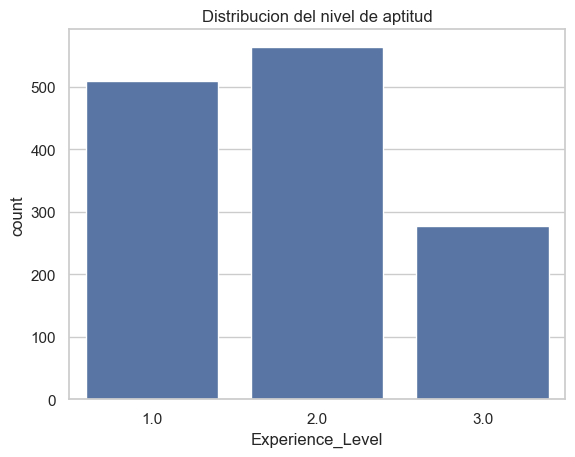

In [5]:
sns.countplot(x="Experience_Level", data=df)
plt.title("Distribucion del nivel de aptitud")
plt.show()

Relacion BPM vs nivel

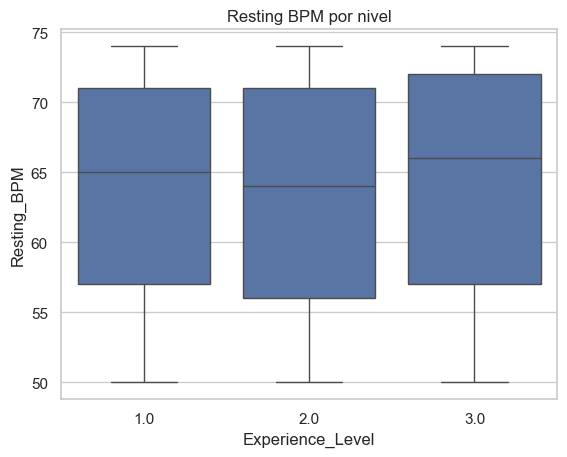

In [6]:
sns.boxplot(
    data=df,
    x="Experience_Level",
    y="Resting_BPM"
)
plt.title("Resting BPM por nivel")
plt.show()


3. Seleccion de features

In [7]:
TARGET = "Experience_Level"

categorical_features = [
    "Gender"
]

numerical_features = [
    "Age",
    "Weight (kg)",
    "Height (m)",
    "BMI",
    "Max_BPM",
    "Avg_BPM",
    "Resting_BPM",
    "Session_Duration (hours)",
    "Fat_Percentage"
]


In [8]:
# Definicion de Input (X) y Target (y)
X = df[categorical_features + numerical_features]
y = df[TARGET]

4. Train/Test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

5. Preprocesamiento

In [10]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

6. Modelo baseline (Logistic Regression)

In [12]:
# Problemas de versiones: TypeError: LogisticRegression.__init__() got an unexpected keyword argument 'multi_class'
# logreg_pipeline = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("model", LogisticRegression(
#         multi_class="multinomial",
#         max_iter=1000,
#         n_jobs=-1
#     ))
# ])

logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000
    ))
])


In [13]:
# Entrenamiento
logreg_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [14]:
# Evaluación
y_pred_lr = logreg_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.4317343173431734
              precision    recall  f1-score   support

         1.0       0.40      0.27      0.33       102
         2.0       0.44      0.78      0.56       113
         3.0       1.00      0.02      0.04        56

    accuracy                           0.43       271
   macro avg       0.61      0.36      0.31       271
weighted avg       0.54      0.43      0.36       271



7. Modelo avanzado: Random Forest

In [15]:
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

In [16]:
# Entrenamiento
rf_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [17]:
# Evaluación
y_pred_rf = rf_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.4095940959409594
              precision    recall  f1-score   support

         1.0       0.40      0.43      0.41       102
         2.0       0.41      0.57      0.48       113
         3.0       0.60      0.05      0.10        56

    accuracy                           0.41       271
   macro avg       0.47      0.35      0.33       271
weighted avg       0.45      0.41      0.37       271



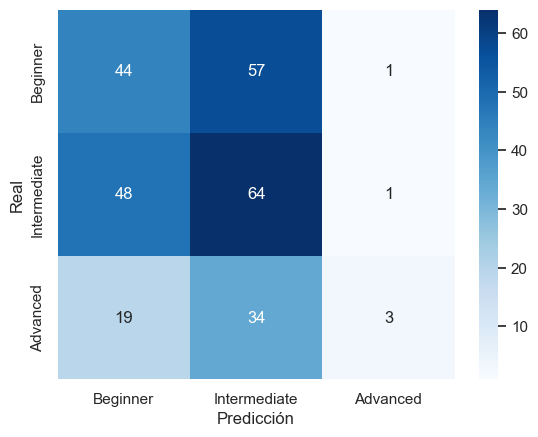

In [18]:
# Matriz de confusion
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Beginner", "Intermediate", "Advanced"],
    yticklabels=["Beginner", "Intermediate", "Advanced"]
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

8. Interpretabilidad

In [19]:
feature_names = (
    rf_pipeline
    .named_steps["preprocessor"]
    .get_feature_names_out()
)

importances = rf_pipeline.named_steps["model"].feature_importances_

feature_importance_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values(by="importance", ascending=False)
)

feature_importance_df.head(10)

,feature,importance
3,num__BMI,0.120201
8,num__Fat_Percentage,0.117991
1,num__Weight (kg),0.117390
7,num__Session_Duration (hours),0.107823
4,num__Max_BPM,0.107735
2,num__Height (m),0.104467
5,num__Avg_BPM,0.102715
0,num__Age,0.101883
6,num__Resting_BPM,0.088281
9,cat__Gender_Female,0.016246


9. Guardar el modelo final

In [20]:
joblib.dump(rf_pipeline, "../models/fitness_level_classifier.pkl")

['../models/fitness_level_classifier.pkl']